In [1]:
%autosave 60

import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import batch_norm, dropout

Autosaving every 60 seconds


Exercise 8


===

Create a DQN to solve the "BipedalWalker-v2" gym.

In [15]:
import gym

env = gym.make("BipedalWalker-v2")
obs = env.reset()
print(obs)

[ 2.74525932e-03  1.41698157e-05 -1.84769344e-03 -1.60000920e-02
  9.26069468e-02  4.28931415e-03  8.59661400e-01 -2.00791967e-03
  1.00000000e+00  3.28922905e-02  4.28913487e-03  8.53472531e-01
 -2.91847034e-03  1.00000000e+00  4.40813214e-01  4.45819318e-01
  4.61421937e-01  4.89549309e-01  5.34101844e-01  6.02459908e-01
  7.09147573e-01  8.85930181e-01  1.00000000e+00  1.00000000e+00]


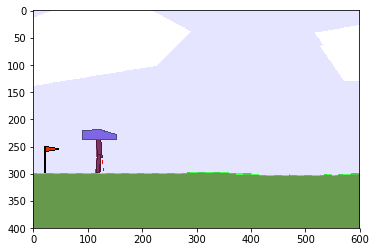

In [16]:
from matplotlib import pyplot as plt

%matplotlib inline
plt.imshow(env.render(mode="rgb_array"))